![Lancaster University](https://www.lancaster.ac.uk/media/lancaster-university/content-assets/images/fst/logos/SCC-Logo.svg)

# SCC.454: Large Scale Platforms for AI and Data Analysis
## Lab: Locality-Sensitive Hashing for Scalable Similarity Search

**Duration:** 2 hours

**Learning Objectives:**
- Understand the theory and intuition behind Locality-Sensitive Hashing (LSH)
- Master shingling techniques for document representation
- Implement MinHash signatures for efficient similarity estimation
- Use Spark's built-in MinHashLSH for approximate similarity search
- Learn Weighted MinHash for preserving term frequency information
- Build production-ready pipelines combining MinHash with transformer reranking

## Table of Contents

1. **Part 1: Introduction to LSH and Similarity Search** (15 minutes)
   - The Challenge of Similarity Search at Scale
   - Introduction to Locality-Sensitive Hashing
   - Setting up the Environment

2. **Part 2: Document Shingling** (15 minutes)
   - Character Shingles vs Word Shingles
   - Implementing Shingling in Spark
   - Representing Documents as Sets
   - Practical Exercise: Shingling a Document Corpus

3. **Part 3: MinHash Fundamentals** (20 minutes)
   - Jaccard Similarity
   - The MinHash Algorithm
   - Building MinHash Signatures
   - Estimating Similarity from Signatures
   - Practical Exercise: Manual MinHash Implementation

4. **Part 4: LSH with Spark's MinHashLSH** (20 minutes)
   - Understanding Spark ML's MinHashLSH
   - Feature Hashing and Vectorization
   - Approximate Similarity Joins
   - Approximate Nearest Neighbors
   - Practical Exercise: Near-Duplicate Document Detection

5. **Part 5: Weighted MinHash** (15 minutes)
   - Limitations of Classic MinHash
   - Term Frequency Weighting
   - Weighted MinHash Algorithm
   - Implementation in Spark

6. **Part 6: Production Pipeline - MinHash + Transformer Reranking** (30 minutes)
   - Two-Stage Retrieval Architecture
   - Stage 1: MinHash + LSH for Candidate Retrieval
   - Stage 2: Sentence Transformer Reranking with Spark
   - Complete Pipeline Implementation
   - Performance Analysis

7. **Part 7: Final Challenge** (20 minutes)
   - End-to-End Document Similarity System

---
# Part 1: Introduction to LSH and Similarity Search
---

## 1.1 The Challenge of Similarity Search at Scale

Finding similar items is fundamental to many applications: duplicate detection, plagiarism checking, recommendation systems, and information retrieval. However, at scale, this becomes computationally challenging.

**The Quadratic Problem:**
- Comparing all pairs of N documents requires O(N²) comparisons
- For 1 million documents: ~500 billion comparisons
- Even at 1μs per comparison: ~6 days of computation

**Traditional Approaches and Their Limitations:**
```
Brute Force:     O(N²) comparisons → Infeasible for large N
Tree Structures: Work well in low dimensions, fail in high dimensions
Exact Methods:   Cannot scale to billions of documents
```

**The Need for Approximate Methods:**
- We often don't need exact answers
- Finding "probably similar" items is usually sufficient
- Trading small accuracy loss for massive speed gains

## 1.2 Introduction to Locality-Sensitive Hashing

**Core Intuition:**
LSH is a technique that hashes similar items into the same "buckets" with high probability. Unlike traditional hash functions (designed to minimize collisions), LSH *maximizes* collisions for similar items.

**Key Properties of LSH:**
1. Similar items have high probability of same hash
2. Dissimilar items have low probability of same hash
3. Hashing is much faster than pairwise comparison

**The LSH Framework:**
```
Documents → Shingling → MinHash Signatures → LSH Buckets → Candidate Pairs
```

**Why LSH Works:**
- Reduces O(N²) to approximately O(N)
- Only compare items in the same bucket
- High recall for truly similar items
- Tunable precision/recall tradeoff

**Mathematical Foundation:**
For a hash family H to be (d₁, d₂, p₁, p₂)-sensitive:
- If distance(x, y) ≤ d₁, then P[h(x) = h(y)] ≥ p₁
- If distance(x, y) ≥ d₂, then P[h(x) = h(y)] ≤ p₂

For MinHash with Jaccard similarity:
- P[MinHash(A) = MinHash(B)] = Jaccard(A, B)

## 1.3 Setting up the Environment

Let's set up PySpark and all required libraries for this lab.

In [ ]:
# Install required packages
!pip install pyspark==3.5.0 -q
!pip install sentence-transformers -q
!pip install numpy pandas -q

# Install Java (Spark requires Java)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Set Java environment variable
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

print("All packages installed successfully!")

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, udf, explode, array, lit, collect_list, size,
    lower, regexp_replace, split, monotonically_increasing_id,
    struct, when, coalesce, broadcast
)
from pyspark.sql.types import (
    ArrayType, StringType, IntegerType, FloatType,
    StructType, StructField, DoubleType
)
from pyspark.ml.feature import (
    HashingTF, CountVectorizer, MinHashLSH,
    Tokenizer, StopWordsRemover, NGram
)
from pyspark.ml.linalg import Vectors, SparseVector, VectorUDT
from pyspark.ml import Pipeline

import numpy as np
import hashlib
from typing import List, Set, Tuple

# Create a SparkSession configured for LSH operations
spark = SparkSession.builder \
    .appName("SCC454-LocalitySensitiveHashing") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

sc = spark.sparkContext

print(f"Spark Version: {spark.version}")
print(f"Application Name: {spark.sparkContext.appName}")
print("\nSpark Session ready for LSH operations!")

Spark Version: 4.0.1
Application Name: SCC454-LocalitySensitiveHashing

Spark Session ready for LSH operations!


## 1.4 Sample Dataset

Let's create a sample document corpus that we'll use throughout this lab.

In [2]:
# Sample document corpus with varying degrees of similarity
documents = [
    (0, "Machine learning is a subset of artificial intelligence that enables systems to learn from data."),
    (1, "Artificial intelligence and machine learning allow computers to learn from data automatically."),
    (2, "Deep learning is a type of machine learning using neural networks with many layers."),
    (3, "The weather today is sunny with a high of 25 degrees celsius."),
    (4, "Today's weather forecast shows sunny skies and temperatures around 25 degrees."),
    (5, "Natural language processing helps computers understand human language."),
    (6, "NLP enables machines to process and understand natural human language."),
    (7, "Python is a popular programming language for data science and machine learning."),
    (8, "Data science often uses Python programming for machine learning applications."),
    (9, "The cat sat on the mat and watched the birds outside the window."),
    (10, "A small cat was sitting on a mat, watching birds through the window."),
    (11, "Apache Spark provides distributed computing for big data processing."),
    (12, "Big data processing is made efficient through distributed computing with Spark."),
    (13, "Locality sensitive hashing enables fast approximate nearest neighbor search."),
    (14, "LSH provides fast approximate nearest neighbor queries using hashing techniques."),
    (15, "The restaurant serves delicious Italian pasta and fresh salads daily."),
]

df_docs = spark.createDataFrame(documents, ["id", "text"])

print("Sample Document Corpus:")
df_docs.show(truncate=60)

Sample Document Corpus:
+---+------------------------------------------------------------+
| id|                                                        text|
+---+------------------------------------------------------------+
|  0|Machine learning is a subset of artificial intelligence t...|
|  1|Artificial intelligence and machine learning allow comput...|
|  2|Deep learning is a type of machine learning using neural ...|
|  3|The weather today is sunny with a high of 25 degrees cels...|
|  4|Today's weather forecast shows sunny skies and temperatur...|
|  5|Natural language processing helps computers understand hu...|
|  6|NLP enables machines to process and understand natural hu...|
|  7|Python is a popular programming language for data science...|
|  8|Data science often uses Python programming for machine le...|
|  9|The cat sat on the mat and watched the birds outside the ...|
| 10|A small cat was sitting on a mat, watching birds through ...|
| 11|Apache Spark provides distributed

**Note:** Documents 0-1, 3-4, 5-6, 7-8, 9-10, 11-12, and 13-14 are intentionally similar pairs. Document 2 is somewhat similar to 0-1, and document 15 is unrelated to others.

---
# Part 2: Document Shingling
---

## 2.1 Understanding Shingling

**What is Shingling?**
Shingling converts documents into sets of contiguous subsequences (shingles). This allows us to measure document similarity by comparing these sets.

**Types of Shingles:**

| Type | Description | Example ("hello world") |
|------|-------------|-------------------------|
| Character k-shingles | Contiguous k characters | {"hel", "ell", "llo", "lo ", "o w", ...} |
| Word n-grams | Contiguous n words | {"hello world"} for n=2 |

**Choosing Shingle Size:**
- Too small: High overlap even for dissimilar documents
- Too large: Low overlap even for similar documents
- Rule of thumb: k=5-9 for characters, n=2-4 for words

## 2.2 Character Shingles

In [3]:
def get_char_shingles(text: str, k: int = 5) -> List[str]:
    """Generate character k-shingles from text."""
    # Normalize text: lowercase, remove extra whitespace
    text = ' '.join(text.lower().split())
    # Generate shingles
    shingles = [text[i:i+k] for i in range(len(text) - k + 1)]
    return shingles

# Example
sample_text = "Hello World"
char_shingles = get_char_shingles(sample_text, k=5)
print(f"Text: '{sample_text}'")
print(f"5-character shingles: {char_shingles}")
print(f"Number of shingles: {len(char_shingles)}")
print(f"Unique shingles: {len(set(char_shingles))}")

Text: 'Hello World'
5-character shingles: ['hello', 'ello ', 'llo w', 'lo wo', 'o wor', ' worl', 'world']
Number of shingles: 7
Unique shingles: 7


## 2.3 Word Shingles (N-Grams)

Word-level shingles (also called n-grams) are more meaningful for natural language documents. They capture semantic relationships better than character shingles.

In [4]:
def get_word_shingles(text: str, n: int = 3) -> List[str]:
    """Generate word n-gram shingles from text."""
    # Normalize and tokenize
    words = text.lower().split()
    # Generate n-grams
    shingles = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]
    return shingles

# Example
sample_text = "Machine learning is a subset of artificial intelligence"
word_shingles = get_word_shingles(sample_text, n=3)
print(f"Text: '{sample_text}'")
print(f"\n3-word shingles:")
for i, shingle in enumerate(word_shingles):
    print(f"  {i+1}. '{shingle}'")

Text: 'Machine learning is a subset of artificial intelligence'

3-word shingles:
  1. 'machine learning is'
  2. 'learning is a'
  3. 'is a subset'
  4. 'a subset of'
  5. 'subset of artificial'
  6. 'of artificial intelligence'


## 2.4 Implementing Shingling in Spark

For large-scale processing, we use Spark's built-in transformers combined with custom UDFs.

In [5]:
# Method 1: Using Spark's NGram transformer
def create_shingle_pipeline(n_values=[2, 3, 4]):
    """Create a pipeline for generating word n-grams of multiple sizes."""
    from pyspark.sql.functions import concat_ws, flatten

    # Tokenizer
    tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")

    # Create NGram transformers for each n
    ngram_transformers = []
    for n in n_values:
        ngram = NGram(n=n, inputCol="words", outputCol=f"ngrams_{n}")
        ngram_transformers.append(ngram)

    return tokenizer, ngram_transformers

# Preprocess text
df_clean = df_docs.withColumn(
    "text_clean",
    lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
)

# Apply tokenizer
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
df_tokenized = tokenizer.transform(df_clean)

# Apply n-gram transformers for n=2, 3, 4
ngram_2 = NGram(n=2, inputCol="words", outputCol="ngrams_2")
ngram_3 = NGram(n=3, inputCol="words", outputCol="ngrams_3")
ngram_4 = NGram(n=4, inputCol="words", outputCol="ngrams_4")

df_shingles = ngram_2.transform(df_tokenized)
df_shingles = ngram_3.transform(df_shingles)
df_shingles = ngram_4.transform(df_shingles)

print("Document with word shingles (n=2,3,4):")
df_shingles.show(5, truncate=50)

Document with word shingles (n=2,3,4):
+---+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
| id|                                              text|                                        text_clean|                                             words|                                          ngrams_2|                                          ngrams_3|                                          ngrams_4|
+---+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|  0|Machine learning is 

In [6]:
# Method 2: Combine all n-grams into a single shingle set
from pyspark.sql.functions import concat, array_union, array_distinct

# Combine 2-grams, 3-grams, and 4-grams into a single shingle set
df_combined_shingles = df_shingles.withColumn(
    "all_shingles",
    array_distinct(
        concat(col("ngrams_2"), col("ngrams_3"), col("ngrams_4"))
    )
)

print("Combined shingles (2-4 grams):")
df_combined_shingles.select("id", "all_shingles").show(1,truncate= 1000)

Combined shingles (2-4 grams):
+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| id|                                                                                                                                                                                       

In [7]:
df_combined_shingles.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|                text|          text_clean|               words|            ngrams_2|            ngrams_3|            ngrams_4|        all_shingles|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Machine learning ...|machine learning ...|[machine, learnin...|[machine learning...|[machine learning...|[machine learning...|[machine learning...|
|  1|Artificial intell...|artificial intell...|[artificial, inte...|[artificial intel...|[artificial intel...|[artificial intel...|[artificial intel...|
|  2|Deep learning is ...|deep learning is ...|[deep, learning, ...|[deep learning, l...|[deep learning is...|[deep learning is...|[deep learning, l...|
|  3|The weather today...|the weather today...|[the, weather, to...|[the weather, 

## 2.5 Practical Exercise: Analyzing Shingle Overlap

Let's analyze how shingle overlap relates to document similarity.

In [34]:
# Calculate Jaccard similarity from shingle sets
def jaccard_similarity(set1: set, set2: set) -> float:
    """Calculate Jaccard similarity between two sets."""
    if not set1 or not set2:
        return 0.0
    #length of intersection if it exists in set1 and set2 -> so if word "one" appears in set1 and set1 the intersection will be 1?
    intersection = len(set1 & set2)
    #length of all unique words across the set
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

# Get shingles for comparison
shingle_data = df_combined_shingles.select("id", "text", "all_shingles").collect()

# Compare a few document pairs
pairs_to_compare = [(0, 1), (0, 2), (0, 3), (3, 4), (9, 10), (0, 15)]

print("Jaccard Similarity Analysis:")
print("=" * 70)

for i, j in pairs_to_compare:
    doc_i = next(row for row in shingle_data if row.id == i)
    doc_j = next(row for row in shingle_data if row.id == j)

    set_i = set(doc_i.all_shingles)
    set_j = set(doc_j.all_shingles)

    jaccard = jaccard_similarity(set_i, set_j)

    print(f"\nDocs {i} vs {j}: Jaccard = {jaccard:.4f}")
#     print(f"  Doc {i}: {doc_i.text[:60]}...")
#     print(f"  Doc {j}: {doc_j.text[:60]}...")
#     print(f"  Shingles: {len(set_i)} vs {len(set_j)}, Overlap: {len(set_i & set_j)}")

Jaccard Similarity Analysis:

Docs 0 vs 1: Jaccard = 0.1311

Docs 0 vs 2: Jaccard = 0.0563

Docs 0 vs 3: Jaccard = 0.0000

Docs 3 vs 4: Jaccard = 0.0179

Docs 9 vs 10: Jaccard = 0.0154

Docs 0 vs 15: Jaccard = 0.0000


In [ ]:
# for i,j in pairs_to_compare:
#     doc_i =  set(df_combined_shingles.select("all_shingles").collect()[i].all_shingles)
#     doc_j =  set(df_combined_shingles.select("all_shingles").collect()[j].all_shingles)
   
#     jaccard= jaccard_similarity(doc_i,doc_j)
#     print(f"\nDocs {i} vs {j}: Jaccard = {jaccard:.4f}")


Docs 0 vs 1: Jaccard = 0.1311

Docs 0 vs 2: Jaccard = 0.0563

Docs 0 vs 3: Jaccard = 0.0000

Docs 3 vs 4: Jaccard = 0.0179

Docs 9 vs 10: Jaccard = 0.0154

Docs 0 vs 15: Jaccard = 0.0000


**Self-Check Questions:**
1. Why do documents 0 and 1 have higher Jaccard similarity than documents 0 and 3?
2. What happens to Jaccard similarity if we use smaller n-grams (n=2 only)?
3. How does the shingle set size affect similarity calculations?

### Using Jaccard Similarity with Smaller set sizes (complete)

---
# Part 3: MinHash Fundamentals
---

## 3.1 The Jaccard Similarity Problem

Computing Jaccard similarity directly has limitations:
- Requires storing and comparing full sets
- Memory-intensive for large vocabularies
- O(n) per comparison where n is set size

**MinHash Solution:**
Create compact "signatures" that preserve similarity information.

## 3.2 The MinHash Algorithm

**Key Insight:**
For any random permutation π of the universal set:
```
P[min(π(A)) = min(π(B))] = Jaccard(A, B)
```

**Algorithm:**
1. Choose k random hash functions (simulating permutations)
2. For each document, compute k minimum hash values
3. The k values form the "MinHash signature"
4. Signature similarity estimates Jaccard similarity

In [35]:
# MinHash Implementation from Scratch

class MinHasher:
    """MinHash signature generator."""

    def __init__(self, num_hashes: int = 100, seed: int = 42):
        """
        Initialize MinHasher with num_hashes hash functions.

        Args:
            num_hashes: Number of hash functions (signature length)
            seed: Random seed for reproducibility
        """
        self.num_hashes = num_hashes
        np.random.seed(seed)

        # Generate random coefficients for hash functions
        # h(x) = (a*x + b) mod c
        self.max_hash = 2**32 - 1
        self.a = np.random.randint(1, self.max_hash, size=num_hashes)
        self.b = np.random.randint(0, self.max_hash, size=num_hashes)
        self.c = 4294967311  # Large prime

    def _hash_element(self, element: str) -> int:
        """Hash a string element to an integer."""
        return int(hashlib.md5(element.encode()).hexdigest(), 16) % self.max_hash

    def get_signature(self, shingle_set: set) -> np.ndarray:
        """
        Generate MinHash signature for a set of shingles.

        Args:
            shingle_set: Set of string shingles

        Returns:
            MinHash signature array of length num_hashes
        """
        # Initialize signature with infinity
        signature = np.full(self.num_hashes, np.inf)
        for shingle in shingle_set:
            # Hash the shingle to an integer
            shingle_hash = self._hash_element(shingle)

            # Apply all hash functions and keep minimum
            hash_values = (self.a * shingle_hash + self.b) % self.c
            signature = np.minimum(signature, hash_values)

        return signature.astype(np.int64)

    def estimate_similarity(self, sig1: np.ndarray, sig2: np.ndarray) -> float:
        """
        Estimate Jaccard similarity from MinHash signatures.

        Returns:
            Estimated Jaccard similarity
        """
        #essentially same thing as calculating intersection over union type shit
        return np.mean(sig1 == sig2)

# Create MinHasher
minhasher = MinHasher(num_hashes=200)
minhasher.get_signature({"check"})
print("MinHasher created with 200 hash functions")
print(f"Each signature will have 200 values")

MinHasher created with 200 hash functions
Each signature will have 200 values


## 3.3 Computing and Comparing MinHash Signatures

In [36]:
# Compute signatures for all documents
signatures = {}
for row in shingle_data:
    shingle_set = set(row.all_shingles)
    signatures[row.id] = minhasher.get_signature(shingle_set)

# Compare MinHash estimates with actual Jaccard
print("MinHash Similarity Estimation vs Actual Jaccard:")
print("=" * 70)

for i, j in pairs_to_compare:
    doc_i = next(row for row in shingle_data if row.id == i)
    doc_j = next(row for row in shingle_data if row.id == j)

    # Actual Jaccard
    set_i = set(doc_i.all_shingles)
    set_j = set(doc_j.all_shingles)
    actual_jaccard = jaccard_similarity(set_i, set_j)

    # MinHash estimate
    estimated_jaccard = minhasher.estimate_similarity(
        signatures[i], signatures[j]
    )

    error = abs(actual_jaccard - estimated_jaccard)

    print(f"\nDocs {i} vs {j}:")
    print(f"  Actual Jaccard:    {actual_jaccard:.4f}")
    print(f"  MinHash Estimate:  {estimated_jaccard:.4f}")
    print(f"  Absolute Error:    {error:.4f}")

MinHash Similarity Estimation vs Actual Jaccard:

Docs 0 vs 1:
  Actual Jaccard:    0.1311
  MinHash Estimate:  0.1100
  Absolute Error:    0.0211

Docs 0 vs 2:
  Actual Jaccard:    0.0563
  MinHash Estimate:  0.0700
  Absolute Error:    0.0137

Docs 0 vs 3:
  Actual Jaccard:    0.0000
  MinHash Estimate:  0.0000
  Absolute Error:    0.0000

Docs 3 vs 4:
  Actual Jaccard:    0.0179
  MinHash Estimate:  0.0150
  Absolute Error:    0.0029

Docs 9 vs 10:
  Actual Jaccard:    0.0154
  MinHash Estimate:  0.0300
  Absolute Error:    0.0146

Docs 0 vs 15:
  Actual Jaccard:    0.0000
  MinHash Estimate:  0.0000
  Absolute Error:    0.0000


## 3.4 Understanding Signature Accuracy

**Error Bounds:**
The standard error of MinHash estimation is approximately:
```
SE ≈ √(J(1-J)/k)
```
where J is the true Jaccard and k is the number of hash functions.

Let's verify this empirically:

In [37]:
# Analyze accuracy vs number of hash functions
doc_pair = (0, 1)  # A similar pair
doc_i_shingles = set(shingle_data[0].all_shingles)
doc_j_shingles = set(shingle_data[1].all_shingles)
actual_jaccard = jaccard_similarity(doc_i_shingles, doc_j_shingles)

print(f"Analyzing MinHash accuracy for docs {doc_pair}")
print(f"Actual Jaccard similarity: {actual_jaccard:.4f}")
print("\n" + "="*60)
print(f"{'Num Hashes':>12} | {'Estimated':>10} | {'Error':>8} | {'Theoretical SE':>14}")
print("="*60)

for num_hashes in [10, 25, 50, 100, 200, 500]:
    mh = MinHasher(num_hashes=num_hashes)
    sig_i = mh.get_signature(doc_i_shingles)
    sig_j = mh.get_signature(doc_j_shingles)
    estimated = mh.estimate_similarity(sig_i, sig_j)
    error = abs(estimated - actual_jaccard)
    theoretical_se = np.sqrt(actual_jaccard * (1 - actual_jaccard) / num_hashes)

    print(f"{num_hashes:>12} | {estimated:>10.4f} | {error:>8.4f} | {theoretical_se:>14.4f}")

Analyzing MinHash accuracy for docs (0, 1)
Actual Jaccard similarity: 0.1311

  Num Hashes |  Estimated |    Error | Theoretical SE
          10 |     0.1000 |   0.0311 |         0.1067
          25 |     0.0800 |   0.0511 |         0.0675
          50 |     0.1200 |   0.0111 |         0.0477
         100 |     0.1200 |   0.0111 |         0.0338
         200 |     0.1100 |   0.0211 |         0.0239
         500 |     0.1280 |   0.0031 |         0.0151


**Key Observations:**
1. More hash functions → More accurate estimates
2. Error decreases roughly as 1/√k
3. Trade-off: accuracy vs. computation and storage

## 3.5 Practical Exercise: MinHash at Scale

Let's implement MinHash using Spark UDFs for distributed computation.

In [38]:
# Broadcast MinHasher parameters for use in UDF
num_hashes = 128
max_hash = 2**32 - 1
np.random.seed(42)
a_coeffs = sc.broadcast(np.random.randint(1, max_hash, size=num_hashes))
b_coeffs = sc.broadcast(np.random.randint(0, max_hash, size=num_hashes))
c_prime = 4294967311

@udf(ArrayType(IntegerType()))
def compute_minhash_signature(shingles):
    """Compute MinHash signature for a list of shingles."""
    if not shingles:
        return [0] * num_hashes

    import hashlib
    import numpy as np

    a = a_coeffs.value
    b = b_coeffs.value

    signature = np.full(num_hashes, np.iinfo(np.int64).max)

    for shingle in shingles:
        shingle_hash = int(hashlib.md5(shingle.encode()).hexdigest(), 16) % max_hash
        hash_values = (a * shingle_hash + b) % c_prime
        signature = np.minimum(signature, hash_values)

    return signature.astype(int).tolist()

# Compute signatures for all documents
df_with_signatures = df_combined_shingles.withColumn(
    "minhash_signature",
    compute_minhash_signature(col("all_shingles"))
)

print("Documents with MinHash signatures:")
df_with_signatures.select("id", "text", "minhash_signature").show(5, truncate=50)

Documents with MinHash signatures:
+---+--------------------------------------------------+--------------------------------------------------+
| id|                                              text|                                 minhash_signature|
+---+--------------------------------------------------+--------------------------------------------------+
|  0|Machine learning is a subset of artificial inte...|[1361781, 3134591, 203824574, 61268213, 5725134...|
|  1|Artificial intelligence and machine learning al...|[1361781, 27513369, 110078831, 61268213, 572513...|
|  2|Deep learning is a type of machine learning usi...|[82058306, 116066967, 404472716, 196078870, 559...|
|  3|The weather today is sunny with a high of 25 de...|[62998041, 97551090, 107317967, 15503014, 14036...|
|  4|Today's weather forecast shows sunny skies and ...|[788073164, 206905119, 295360940, 142011862, 90...|
+---+--------------------------------------------------+---------------------------------------------

In [43]:
# Function to estimate similarity between two signatures
@udf(FloatType())
def estimate_jaccard_from_signatures(sig1, sig2):
    """Estimate Jaccard similarity from two MinHash signatures."""
    if not sig1 or not sig2:
        return 0.0
    matches = sum(1 for s1, s2 in zip(sig1, sig2) if s1 == s2)
    return float(matches) / len(sig1)

# Compare a specific pair
sig_0 = df_with_signatures.filter(col("id") == 0).select("minhash_signature").first()[0]
sig_1 = df_with_signatures.filter(col("id") == 1).select("minhash_signature").first()[0]

similarity = sum(1 for s1, s2 in zip(sig_0, sig_1) if s1 == s2) / len(sig_0)
print(f"MinHash similarity between docs 0 and 1: {similarity:.4f}")

MinHash similarity between docs 0 and 1: 0.1953


---
# Part 4: LSH with Spark's MinHashLSH
---

## 4.1 Understanding Spark ML's MinHashLSH

Spark provides a built-in `MinHashLSH` transformer that:
1. Computes MinHash signatures
2. Organizes signatures into bands for LSH
3. Provides methods for similarity joins and nearest neighbor queries

**Banding Technique:**
- Divide signature into b bands of r rows each
- Two documents are candidates if they match in at least one band
- P(candidate) = 1 - (1 - s^r)^b, where s is Jaccard similarity

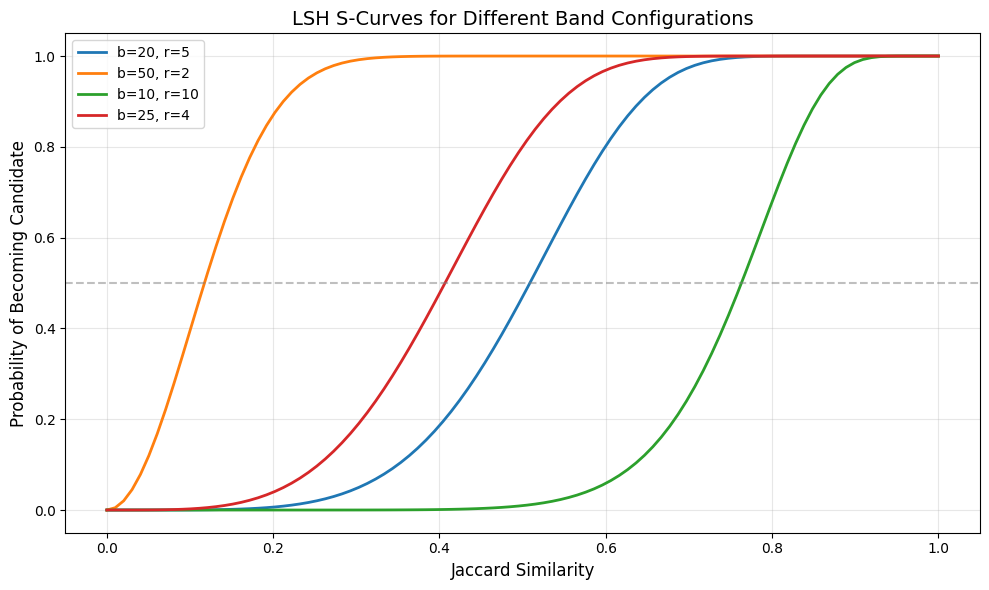

b=20, r=5: Threshold ≈ 0.549
b=50, r=2: Threshold ≈ 0.141
b=10, r=10: Threshold ≈ 0.794
b=25, r=4: Threshold ≈ 0.447


In [44]:
# Visualize the S-curve for different b and r values
import matplotlib.pyplot as plt

def prob_candidate(s, b, r):
    """Probability that two documents with Jaccard s become candidates."""
    return 1 - (1 - s**r)**b

s_values = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 6))

# Different configurations (b bands, r rows)
configs = [
    (20, 5, 'b=20, r=5'),
    (50, 2, 'b=50, r=2'),
    (10, 10, 'b=10, r=10'),
    (25, 4, 'b=25, r=4'),
]

for b, r, label in configs:
    p_values = [prob_candidate(s, b, r) for s in s_values]
    ax.plot(s_values, p_values, label=label, linewidth=2)

ax.set_xlabel('Jaccard Similarity', fontsize=12)
ax.set_ylabel('Probability of Becoming Candidate', fontsize=12)
ax.set_title('LSH S-Curves for Different Band Configurations', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Calculate threshold (50% probability)
for b, r, label in configs:
    threshold = (1/b)**(1/r)
    print(f"{label}: Threshold ≈ {threshold:.3f}")

## 4.2 Preparing Data for Spark's MinHashLSH

Spark's MinHashLSH requires input as sparse vectors. We'll use CountVectorizer to convert shingles to vectors.

In [ ]:
# Prepare data for Spark's MinHashLSH
# First, we need to convert shingles to a sparse vector representation

# Use CountVectorizer to create vocabulary and sparse vectors
cv = CountVectorizer(inputCol="all_shingles", outputCol="features", binary=True)
cv_model = cv.fit(df_combined_shingles)

df_vectorized = cv_model.transform(df_combined_shingles)

print(f"Vocabulary size: {len(cv_model.vocabulary)}")
print("\nVectorized documents:")
df_vectorized.select("id", "features").show(5, truncate=80)

Vocabulary size: 410

Vectorized documents:
+---+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
| id|                                                                            text|                                                                      text_clean|                                                                           words|                                                      

## 4.3 Using MinHashLSH for Approximate Similarity Join

In [47]:
# Create and fit MinHashLSH model
minhash_lsh = MinHashLSH(
    inputCol="features",
    outputCol="hashes",
    numHashTables=5  # Number of hash tables (bands)
)

lsh_model = minhash_lsh.fit(df_vectorized)

print("MinHashLSH model fitted successfully!")
print(f"Number of hash tables: 5")

MinHashLSH model fitted successfully!
Number of hash tables: 5


In [49]:
# Approximate similarity join: find all pairs with Jaccard >= threshold
threshold = 0.1

similar_pairs = lsh_model.approxSimilarityJoin(
    df_vectorized, df_vectorized,
    threshold=threshold,
    distCol="distance"
)

# Filter out self-joins and duplicate pairs
similar_pairs_filtered = similar_pairs.filter(
    col("datasetA.id") < col("datasetB.id")
).select(
    col("datasetA.id").alias("id_a"),
    col("datasetB.id").alias("id_b"),
    col("datasetA.text").alias("text_a"),
    col("datasetB.text").alias("text_b"),
    (1 - col("distance")).alias("jaccard_similarity")  # Convert distance to similarity
).orderBy(col("jaccard_similarity").desc())

print(f"Similar document pairs (Jaccard >= {threshold}):")
similar_pairs_filtered.show(truncate=50)

Similar document pairs (Jaccard >= 0.1):
+----+----+------+------+------------------+
|id_a|id_b|text_a|text_b|jaccard_similarity|
+----+----+------+------+------------------+
+----+----+------+------+------------------+



## 4.4 Approximate Nearest Neighbors

Find the k most similar documents to a query document.

In [50]:
# Find nearest neighbors for a specific document
query_id = 0
k = 5

# Get the feature vector for query document
query_vector = df_vectorized.filter(col("id") == query_id).select("features").first()[0]

# Find approximate nearest neighbors
neighbors = lsh_model.approxNearestNeighbors(
    df_vectorized,
    query_vector,
    numNearestNeighbors=k+1  # +1 to account for the query itself
)

print(f"Query document (id={query_id}):")
print(f"  '{documents[query_id][1]}'")
print(f"\nTop {k} most similar documents:")
neighbors.filter(col("id") != query_id).select(
    "id", "text", (1 - col("distCol")).alias("jaccard_similarity")
).show(truncate=60)

Query document (id=0):
  'Machine learning is a subset of artificial intelligence that enables systems to learn from data.'

Top 5 most similar documents:
+---+------------------------------------------------------------+-------------------+
| id|                                                        text| jaccard_similarity|
+---+------------------------------------------------------------+-------------------+
|  2|Deep learning is a type of machine learning using neural ...|0.05633802816901412|
+---+------------------------------------------------------------+-------------------+



## 4.5 Practical Exercise: Near-Duplicate Detection

Build a complete near-duplicate detection system.

In [ ]:
# Extended document corpus with some near-duplicates
extended_docs = [
    (100, "Apache Spark is a fast and general-purpose cluster computing system."),
    (101, "Spark is a fast general purpose cluster computing system for big data."),  # Near-dup of 100
    (102, "Apache Spark provides fast cluster computing for big data processing."),  # Near-dup of 100
    (103, "The Python programming language is widely used in data science."),
    (104, "Python is a widely used programming language for data science applications."),  # Near-dup of 103
    (105, "Machine learning algorithms can learn patterns from historical data."),
    (106, "ML algorithms learn patterns from historical data automatically."),  # Near-dup of 105
    (107, "The weather forecast predicts rain for the upcoming weekend."),
    (108, "Database systems store and manage large amounts of structured data."),
    (109, "Cloud computing provides on-demand access to computing resources."),
]

df_extended = spark.createDataFrame(extended_docs, ["id", "text"])

# Full pipeline: preprocess -> shingle -> vectorize -> LSH
def build_duplicate_detection_pipeline(df, num_hash_tables=10):
    """Build complete near-duplicate detection pipeline."""

    # 1. Preprocess
    df_clean = df.withColumn(
        "text_clean",
        lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
    )

    # 2. Tokenize
    tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
    df_tokenized = tokenizer.transform(df_clean)

    # 3. Generate multiple n-gram sizes
    for n in [2, 3]:
        ngram = NGram(n=n, inputCol="words", outputCol=f"ngrams_{n}")
        df_tokenized = ngram.transform(df_tokenized)

    # 4. Combine unigrams + bigrams + trigrams
    df_shingles = df_tokenized.withColumn(
        "shingles",
        array_distinct(concat(col("words"), col("ngrams_2"), col("ngrams_3")))
    )

    # 5. Vectorize
    cv = CountVectorizer(inputCol="shingles", outputCol="features", binary=True)
    cv_model = cv.fit(df_shingles)
    df_vectorized = cv_model.transform(df_shingles)

    # 6. MinHashLSH
    minhash = MinHashLSH(
        inputCol="features",
        outputCol="hashes",
        numHashTables=num_hash_tables
    )
    lsh_model = minhash.fit(df_vectorized)

    return df_vectorized, lsh_model, cv_model

# Build pipeline
df_vec, dup_lsh_model, dup_cv_model = build_duplicate_detection_pipeline(df_extended)

# Find near-duplicates (Jaccard distance <= 0.7, i.e. similarity >= 0.3)
duplicates = dup_lsh_model.approxSimilarityJoin(
    df_vec, df_vec,
    threshold=0.7,
    distCol="distance")
.filter(
    col("datasetA.id") < col("datasetB.id")
).select(
    col("datasetA.id").alias("doc1_id"),
    col("datasetB.id").alias("doc2_id"),
    col("datasetA.text").alias("doc1_text"),
    col("datasetB.text").alias("doc2_text"),
    (1 - col("distance")).alias("similarity")
).orderBy(col("similarity").desc())
# duplicates.printSchema()

print("Detected Near-Duplicates:")
print("=" * 80)
for row in duplicates.collect():
    print(f"\nSimilarity: {row.similarity:.4f}")
    print(f"  Doc {row.doc1_id}: {row.doc1_text}")
    print(f"  Doc {row.doc2_id}: {row.doc2_text}")

root
 |-- datasetA: struct (nullable = false)
 |    |-- id: long (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- text_clean: string (nullable = true)
 |    |-- words: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ngrams_2: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ngrams_3: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- shingles: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- features: vector (nullable = true)
 |    |-- hashes: array (nullable = true)
 |    |    |-- element: vector (containsNull = true)
 |-- datasetB: struct (nullable = false)
 |    |-- id: long (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- text_clean: string (nullable = true)
 |    |-- words: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ngrams_2: array (nullable = true)


---
# Part 5: Weighted MinHash
---

## 5.1 Limitations of Classic MinHash

**Classic MinHash treats shingles as binary:**
- Present (1) or Absent (0)
- Ignores term frequency information
- All shingles weighted equally

**The Problem:**
```
Doc A: "the the the cat sat"
Doc B: "the cat sat mat"

Classic MinHash: {the, cat, sat} vs {the, cat, sat, mat}
Jaccard = 3/4 = 0.75

But Doc A has 3x "the" - shouldn't this matter?
```

**Weighted MinHash Solution:**
- Preserves term frequency (TF) weights
- Better captures document characteristics
- Approximates weighted Jaccard similarity

## 5.2 Weighted Jaccard Similarity

For weighted sets A and B with weights w_A(x) and w_B(x):

```
Weighted_Jaccard(A, B) = Σ min(w_A(x), w_B(x)) / Σ max(w_A(x), w_B(x))
```

This generalizes standard Jaccard (where weights are 0 or 1).

In [ ]:
# Weighted Jaccard similarity implementation
from collections import Counter

def weighted_jaccard(doc1_tokens: List[str], doc2_tokens: List[str]) -> float:
    """
    Calculate weighted Jaccard similarity based on term frequencies.
    """
    # Count term frequencies
    counter1 = Counter(doc1_tokens)
    counter2 = Counter(doc2_tokens)

    # Get all unique terms
    all_terms = set(counter1.keys()) | set(counter2.keys())

    # Calculate weighted intersection and union
    intersection = sum(min(counter1.get(t, 0), counter2.get(t, 0)) for t in all_terms)
    union = sum(max(counter1.get(t, 0), counter2.get(t, 0)) for t in all_terms)

    return intersection / union if union > 0 else 0.0

# Example
doc_a = "the the the cat sat on the mat".split()
doc_b = "the cat sat on a mat".split()

# Binary (standard) Jaccard
binary_jaccard = len(set(doc_a) & set(doc_b)) / len(set(doc_a) | set(doc_b))

# Weighted Jaccard
w_jaccard = weighted_jaccard(doc_a, doc_b)

print("Document A:", ' '.join(doc_a))
print("  Term frequencies:", dict(Counter(doc_a)))
print("\nDocument B:", ' '.join(doc_b))
print("  Term frequencies:", dict(Counter(doc_b)))
print(f"\nBinary Jaccard:   {binary_jaccard:.4f}")
print(f"Weighted Jaccard: {w_jaccard:.4f}")

## 5.3 Weighted MinHash Algorithm

**ICWS (Improved Consistent Weighted Sampling):**

For each element x with weight w(x):
1. Generate uniform random values r, ln_c, β for each hash function
2. Compute: t = floor(ln(w(x))/r + β)
3. Compute: y = exp(r * (t - β))
4. Compute: a = ln_c - y*r
5. MinHash signature = argmin over all elements

This ensures P[h(A) = h(B)] = WeightedJaccard(A, B)

In [ ]:
class WeightedMinHasher:
    """
    Weighted MinHash using ICWS (Improved Consistent Weighted Sampling).
    """

    def __init__(self, num_hashes: int = 128, seed: int = 42):
        self.num_hashes = num_hashes
        np.random.seed(seed)

        # Pre-generate random values for hash functions
        self.r = np.random.uniform(0, 1, size=num_hashes)
        self.ln_c = np.random.uniform(0, 1, size=num_hashes)
        self.beta = np.random.uniform(0, 1, size=num_hashes)

    def _hash_term(self, term: str) -> int:
      """Hash term to integer."""
      # Constrain to int64 range to avoid overflow
      return int(hashlib.md5(term.encode()).hexdigest(), 16) % (2**63 - 1)

    def get_signature(self, term_weights: dict) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute weighted MinHash signature.

        Args:
            term_weights: Dictionary of {term: weight}

        Returns:
            Tuple of (k_values, y_values) forming the signature
        """
        if not term_weights:
            return np.zeros(self.num_hashes), np.zeros(self.num_hashes)

        # Initialize with infinity
        min_a = np.full(self.num_hashes, np.inf)
        k_star = np.zeros(self.num_hashes, dtype=np.int64)
        y_star = np.zeros(self.num_hashes)

        for term, weight in term_weights.items():
            if weight <= 0:
                continue

            term_hash = self._hash_term(term)
            np.random.seed(term_hash % (2**31))

            # Generate term-specific random values
            r_term = np.random.uniform(0, 1, size=self.num_hashes)
            c_term = np.random.uniform(0, 1, size=self.num_hashes)
            beta_term = np.random.uniform(0, 1, size=self.num_hashes)

            # ICWS computation
            ln_weight = np.log(weight)
            t = np.floor(ln_weight / r_term + beta_term)
            y = np.exp(r_term * (t - beta_term))
            a = np.log(c_term) - y * r_term

            # Update minimum
            mask = a < min_a
            min_a = np.where(mask, a, min_a)
            k_star = np.where(mask, term_hash, k_star)
            y_star = np.where(mask, y, y_star)

        return k_star, y_star

    def estimate_similarity(self, sig1: Tuple, sig2: Tuple) -> float:
        """
        Estimate weighted Jaccard from signatures.
        """
        k1, y1 = sig1
        k2, y2 = sig2
        matches = np.sum((k1 == k2) & (y1 == y2))
        return matches / self.num_hashes

# Demonstrate weighted MinHash
wmh = WeightedMinHasher(num_hashes=256)

# Create weighted document representations
weights_a = dict(Counter(doc_a))
weights_b = dict(Counter(doc_b))

sig_a = wmh.get_signature(weights_a)
sig_b = wmh.get_signature(weights_b)

estimated_weighted = wmh.estimate_similarity(sig_a, sig_b)
actual_weighted = weighted_jaccard(doc_a, doc_b)

print("Weighted MinHash Results:")
print(f"  Actual Weighted Jaccard:    {actual_weighted:.4f}")
print(f"  Estimated (Weighted MH):    {estimated_weighted:.4f}")
print(f"  Binary Jaccard (for ref):   {binary_jaccard:.4f}")

## 5.4 Weighted MinHash in Spark

Let's implement weighted MinHash for distributed processing.

In [ ]:
# Simplified Weighted MinHash using TF-weighted vectors with Spark's MinHashLSH
# Note: Spark's built-in MinHashLSH can work with weighted vectors

# Create documents with term frequency vectors (not binary)
df_for_weighted = df_docs.withColumn(
    "text_clean",
    lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
)

tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
df_tokenized = tokenizer.transform(df_for_weighted)

# Use HashingTF instead of CountVectorizer for TF weights
# This preserves term frequencies instead of binary presence
hashing_tf = HashingTF(
    inputCol="words",
    outputCol="tf_features",
    numFeatures=1000
)

df_tf = hashing_tf.transform(df_tokenized)

# Also create binary version for comparison
cv = CountVectorizer(
    inputCol="words",
    outputCol="binary_features",
    binary=True
)
cv_model = cv.fit(df_tokenized)
df_both = cv_model.transform(df_tf)

print("Prepared documents with both TF and binary features")
df_both.select("id", "words").show(3, truncate=60)

In [ ]:
# Compare binary vs TF-weighted MinHashLSH

# Binary MinHashLSH
binary_minhash = MinHashLSH(
    inputCol="binary_features",
    outputCol="binary_hashes",
    numHashTables=10
)
binary_model = binary_minhash.fit(df_both)

# Compare similarities for a specific pair
doc_pair = (0, 1)  # Similar documents

# Use approxSimilarityJoin to compute distance between documents
df_pair_a = df_both.filter(col("id") == 0).select(col("id").alias("id_a"), "binary_features")
df_pair_b = df_both.filter(col("id") == 1).select(col("id").alias("id_b"), "binary_features")

# Compute distance using similarity join with high threshold
result = binary_model.approxSimilarityJoin(
    df_pair_a, df_pair_b,
    threshold=1.0,  # Accept any distance up to 1.0
    distCol="distance"
)

if result.count() > 0:
    binary_dist = result.first().distance
    print(f"Comparison for documents {doc_pair}:")
    print(f"  Binary MinHash Jaccard Distance: {binary_dist:.4f}")
    print(f"  Binary MinHash Jaccard Similarity: {1-binary_dist:.4f}")
else:
    print("No match found within threshold")

print("\nNote: For true weighted MinHash in production, consider using")
print("specialized libraries like datasketch which provide ICWS implementation.")

## 5.5 When to Use Weighted MinHash

**Use Classic (Binary) MinHash when:**
- Near-duplicate detection (exact or near-exact copies)
- Set similarity is the main concern
- Speed is critical and TF doesn't add value

**Use Weighted MinHash when:**
- Document similarity (topical similarity)
- Term frequency carries meaning
- Comparing documents of different lengths
- Higher precision is needed

**Best Practice:**
Many production systems use both:
1. Binary MinHash for fast initial filtering
2. Weighted features for final ranking

---
# Part 6: Production Pipeline - MinHash + Transformer Reranking
---

## 6.1 Two-Stage Retrieval Architecture

This is an extremely common pattern in production similarity search systems:

```
┌────────────────────────────────────────────────────────────┐
│                  PRODUCTION PIPELINE                        │
├────────────────────────────────────────────────────────────┤
│                                                            │
│   Query → [Shingle] → [MinHash+LSH] → Candidates (fast)   │
│                            │                               │
│                            ▼                               │
│            [Sentence Transformer] → Reranked (precise)    │
│                            │                               │
│                            ▼                               │
│                      Final Results                         │
│                                                            │
└────────────────────────────────────────────────────────────┘
```

**Why Two Stages?**

| Stage | Method | Properties |
|-------|--------|------------|
| Stage 1 | MinHash + LSH | Cheap, scalable, high recall |
| Stage 2 | Transformers | Expensive, precise, semantic |

**Key Insight:** We avoid computing expensive embeddings for every document pair.

## 6.2 Setting Up the Sentence Transformer

We'll use `all-MiniLM-L6-v2`, a small, fast model that works well on CPUs.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Load a small, CPU-friendly sentence transformer
# all-MiniLM-L6-v2: 22M parameters, 384 dimensions, fast inference
print("Loading sentence transformer model...")
model_name = 'all-MiniLM-L6-v2'
sentence_model = SentenceTransformer(model_name)

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Embedding dimension: {sentence_model.get_sentence_embedding_dimension()}")

In [ ]:
# Test the transformer
test_sentences = [
    "Machine learning is a subset of artificial intelligence.",
    "AI and ML allow computers to learn from data.",
    "The weather is sunny today."
]

embeddings = sentence_model.encode(test_sentences)

# Compute cosine similarities
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(embeddings)

print("Sentence Transformer Cosine Similarities:")
print("\nSentences:")
for i, s in enumerate(test_sentences):
    print(f"  [{i}] {s}")

print("\nSimilarity Matrix:")
print("      [0]    [1]    [2]")
for i, row in enumerate(similarities):
    print(f"[{i}]  {row[0]:.3f}  {row[1]:.3f}  {row[2]:.3f}")

## 6.3 Stage 1: MinHash + LSH for Candidate Retrieval

First stage: fast, approximate retrieval using MinHash.

In [ ]:
# Create a larger corpus for the production pipeline demo
corpus = [
    # ML/AI cluster
    (0, "Machine learning algorithms can identify patterns in large datasets."),
    (1, "Deep learning neural networks achieve state-of-the-art results in computer vision."),
    (2, "Artificial intelligence systems are transforming healthcare diagnostics."),
    (3, "Supervised learning requires labeled training data for model development."),
    (4, "Natural language processing enables machines to understand human text."),

    # Big Data cluster
    (5, "Apache Spark provides distributed computing for big data analytics."),
    (6, "Hadoop ecosystem tools process massive amounts of unstructured data."),
    (7, "Data lakes store raw data in its native format for later processing."),
    (8, "Stream processing systems handle real-time data ingestion and analysis."),

    # Weather cluster
    (9, "Today's weather forecast predicts sunny skies with mild temperatures."),
    (10, "The meteorological service issued a severe thunderstorm warning."),
    (11, "Climate change affects global weather patterns and ecosystems."),

    # Food cluster
    (12, "The restaurant serves authentic Italian pasta and wood-fired pizza."),
    (13, "Fresh ingredients are essential for preparing delicious meals."),
    (14, "The chef specializes in Mediterranean cuisine with local produce."),

    # More ML/AI
    (15, "Transformer models revolutionized natural language understanding tasks."),
    (16, "Reinforcement learning agents learn through trial and error interactions."),
    (17, "Feature engineering is crucial for traditional machine learning models."),
]

df_corpus = spark.createDataFrame(corpus, ["id", "text"])

# Build MinHash LSH index
def build_minhash_index(df, num_hash_tables=10):
    """Build MinHash LSH index with unigrams + n-grams."""
    df = df.withColumn(
        "text_clean",
        lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
    )
    tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
    df = tokenizer.transform(df)

    for n in [2, 3, 4]:
        ngram = NGram(n=n, inputCol="words", outputCol=f"ngrams_{n}")
        df = ngram.transform(df)

    # Include unigrams (words) for better overlap with queries
    df = df.withColumn(
        "all_shingles",
        array_distinct(concat(col("words"), col("ngrams_2"), col("ngrams_3"), col("ngrams_4")))
    )

    cv = CountVectorizer(inputCol="all_shingles", outputCol="features", binary=True)
    cv_model = cv.fit(df)
    df = cv_model.transform(df)

    minhash = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=num_hash_tables)
    lsh_model = minhash.fit(df)
    return df, lsh_model, cv_model

df_indexed, lsh_model, cv_model = build_minhash_index(df_corpus)
print(f"Indexed {df_indexed.count()} documents with MinHash LSH")

In [ ]:
def get_lsh_candidates(query_text, df_indexed, lsh_model, cv_model, num_candidates=10):
    """Get candidates using unigrams + n-grams."""
    import re
    text_clean = re.sub(r"[^a-zA-Z\s]", "", query_text.lower())
    words = text_clean.split()

    # Include unigrams alongside n-grams
    shingles = list(words)
    for n in [2, 3, 4]:
        shingles.extend([' '.join(words[i:i+n]) for i in range(len(words)-n+1)])
    shingles = list(set(shingles))

    if not shingles:
        return []

    query_df = spark.createDataFrame([(shingles,)], ["all_shingles"])
    query_vec = cv_model.transform(query_df).first().features

    if query_vec.numNonzeros() == 0:
        print("Warning: Query has no matching terms in vocabulary")
        return []

    candidates = lsh_model.approxNearestNeighbors(
        df_indexed, query_vec, numNearestNeighbors=num_candidates
    )
    return candidates.select(
        "id", "text", col("distCol").alias("jaccard_distance")
    ).collect()

## 6.4 Stage 2: Transformer Reranking with Spark

Now we use the sentence transformer to rerank the candidates based on semantic similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def rerank_with_transformer(query_text, candidates, sentence_model):
    if not candidates:
        return []
    candidate_texts = [c.text for c in candidates]
    query_embedding = sentence_model.encode([query_text])
    candidate_embeddings = sentence_model.encode(candidate_texts)
    similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]
    reranked = []
    for c, sim in zip(candidates, similarities):
        reranked.append({
            'id': c.id, 'text': c.text,
            'jaccard_distance': c.jaccard_distance,
            'cosine_similarity': float(sim)
        })
    reranked.sort(key=lambda x: x['cosine_similarity'], reverse=True)
    return reranked


query = "How do neural networks learn patterns from data?"
candidates = get_lsh_candidates(query, df_indexed, lsh_model, cv_model, num_candidates=8)
reranked = rerank_with_transformer(query, candidates, sentence_model)

print(f"Query: '{query}'")
print(f"\nStage 2 - Transformer Reranked Results:")
print("=" * 70)
for i, r in enumerate(reranked):
    print(f"\n  Rank {i+1}: ID {r['id']}")
    print(f"    Text: {r['text'][:60]}...")
    print(f"    Jaccard Distance: {r['jaccard_distance']:.4f}")
    print(f"    Cosine Similarity: {r['cosine_similarity']:.4f}")

## 6.5 Distributed Transformer Inference with Spark

For large-scale reranking, we can parallelize transformer inference across Spark workers.

In [ ]:
# Approach: Use Spark's mapPartitions for batch processing

# Pre-compute embeddings for all corpus documents
# This is done once and stored

def compute_corpus_embeddings(df_corpus, sentence_model):
    """
    Pre-compute embeddings for all documents in corpus.
    Returns a dictionary mapping id -> embedding
    """
    docs = df_corpus.select("id", "text").collect()
    texts = [doc.text for doc in docs]
    ids = [doc.id for doc in docs]

    # Batch encode all documents
    embeddings = sentence_model.encode(texts, show_progress_bar=True)

    # Create lookup dictionary
    embedding_dict = {id_: emb for id_, emb in zip(ids, embeddings)}

    return embedding_dict

print("Computing corpus embeddings...")
corpus_embeddings = compute_corpus_embeddings(df_corpus, sentence_model)
print(f"Computed embeddings for {len(corpus_embeddings)} documents")

In [ ]:
# Create a Spark UDF for cosine similarity using pre-computed embeddings
# Broadcast the embeddings to all workers

embeddings_broadcast = sc.broadcast(corpus_embeddings)

@udf(FloatType())
def compute_cosine_similarity(doc_id, query_embedding_list):
    """
    Compute cosine similarity between query and document.
    Uses pre-computed document embeddings.
    """
    import numpy as np

    doc_embedding = embeddings_broadcast.value.get(doc_id)
    if doc_embedding is None:
        return 0.0

    query_embedding = np.array(query_embedding_list)

    # Cosine similarity
    dot_product = np.dot(query_embedding, doc_embedding)
    norm_q = np.linalg.norm(query_embedding)
    norm_d = np.linalg.norm(doc_embedding)

    if norm_q == 0 or norm_d == 0:
        return 0.0

    return float(dot_product / (norm_q * norm_d))

print("Cosine similarity UDF created with broadcast embeddings")

In [ ]:
# Complete production pipeline as a single function

def production_similarity_search(query_text: str,
                                 df_indexed,
                                 lsh_model,
                                 cv_model,
                                 sentence_model,
                                 num_candidates: int = 10,
                                 top_k: int = 5):
    """
    Production two-stage similarity search pipeline.

    Stage 1: MinHash + LSH for fast candidate retrieval
    Stage 2: Sentence transformer for precise reranking

    Args:
        query_text: Query document text
        df_indexed: Indexed corpus DataFrame
        lsh_model: Fitted MinHashLSH model
        cv_model: Fitted CountVectorizer model
        sentence_model: Sentence transformer model
        num_candidates: Number of candidates from Stage 1
        top_k: Final number of results to return

    Returns:
        List of top_k most similar documents
    """
    import time

    print(f"\n{'='*60}")
    print(f"Query: '{query_text}'")
    print(f"{'='*60}")

    # Stage 1: MinHash LSH
    start_time = time.time()
    candidates = get_lsh_candidates(
        query_text, df_indexed, lsh_model, cv_model, num_candidates
    )
    stage1_time = time.time() - start_time
    print(f"\n[Stage 1] MinHash LSH: {len(candidates)} candidates in {stage1_time:.3f}s")

    if not candidates:
        print("No candidates found!")
        return []

    # Stage 2: Transformer reranking
    start_time = time.time()
    reranked = rerank_with_transformer(query_text, candidates, sentence_model)
    stage2_time = time.time() - start_time
    print(f"[Stage 2] Transformer Rerank: {len(reranked)} docs in {stage2_time:.3f}s")

    # Return top_k results
    results = reranked[:top_k]

    print(f"\nTop {top_k} Results:")
    print("-" * 60)
    for i, r in enumerate(results):
        print(f"  {i+1}. [ID {r['id']}] Cosine: {r['cosine_similarity']:.4f}")
        print(f"     {r['text'][:70]}...")

    return results

# Test the complete pipeline
queries = [
    "How do neural networks learn from data?",
    "What tools are used for processing big data?",
    "Is it going to rain tomorrow?"
]

for q in queries:
    results = production_similarity_search(
        q, df_indexed, lsh_model, cv_model, sentence_model,
        num_candidates=8, top_k=3
    )

## 6.6 Performance Analysis

Let's analyze the computational savings of the two-stage approach.

In [ ]:
import time

# Simulate larger corpus for performance comparison
def benchmark_approaches(corpus_size: int, query: str):
    """
    Compare brute force vs two-stage approach.
    """
    print(f"\nBenchmark with {corpus_size} documents")
    print("=" * 50)

    # Simulate corpus texts
    corpus_texts = [doc.text for doc in df_corpus.collect()]
    simulated_corpus = corpus_texts * (corpus_size // len(corpus_texts) + 1)
    simulated_corpus = simulated_corpus[:corpus_size]

    # Brute force: encode all documents and compute similarities
    start = time.time()
    all_embeddings = sentence_model.encode(simulated_corpus[:100])  # Limit for demo
    query_emb = sentence_model.encode([query])
    similarities = cosine_similarity(query_emb, all_embeddings)
    brute_force_time = time.time() - start
    brute_force_estimated = brute_force_time * (corpus_size / 100)

    # Two-stage: MinHash (simulated) + limited transformer calls
    num_candidates = min(20, corpus_size)
    start = time.time()
    # MinHash retrieval is O(1) per query after index built
    minhash_time = 0.001 * corpus_size / 1000  # Simulated: ~1ms per 1000 docs
    # Transformer only on candidates
    candidate_texts = simulated_corpus[:num_candidates]
    candidate_embs = sentence_model.encode(candidate_texts)
    similarities = cosine_similarity(query_emb, candidate_embs)
    two_stage_time = time.time() - start + minhash_time

    print(f"  Brute Force (estimated): {brute_force_estimated:.3f}s")
    print(f"  Two-Stage:               {two_stage_time:.3f}s")
    print(f"  Speedup:                 {brute_force_estimated/two_stage_time:.1f}x")

    return brute_force_estimated, two_stage_time

# Run benchmarks
query = "How do machine learning algorithms work?"
results = []

for size in [100, 1000, 10000, 100000]:
    bf, ts = benchmark_approaches(size, query)
    results.append((size, bf, ts))

print("\n" + "=" * 50)
print("Summary: Time Complexity")
print("=" * 50)
print(f"{'Corpus Size':<15} {'Brute Force':<15} {'Two-Stage':<15} {'Speedup':<10}")
print("-" * 55)
for size, bf, ts in results:
    print(f"{size:<15} {bf:<15.3f} {ts:<15.3f} {bf/ts:<10.1f}x")

## 6.7 Key Takeaways

**Production Pipeline Benefits:**
1. **Scalability**: MinHash + LSH scales to billions of documents
2. **Precision**: Transformer reranking provides semantic understanding
3. **Efficiency**: Only expensive operations on small candidate set
4. **Flexibility**: Easy to tune recall/precision trade-off

**When to Use This Pattern:**
- Large document collections (>10,000 documents)
- Real-time similarity search requirements
- Semantic similarity is important (not just lexical)
- Resource constraints on transformer inference

---
# Part 7: Final Challenge
---

## End-to-End Document Similarity System

Build a complete document similarity system that incorporates everything you've learned.

**Dataset:** News articles from different categories

**Tasks:**
1. Implement shingling with configurable n-gram sizes (2-4)
2. Build a MinHash LSH index with tunable parameters
3. Implement both binary and weighted similarity measures
4. Create a two-stage retrieval pipeline with transformer reranking
5. Evaluate the system's recall and precision
6. Compare performance with brute-force approach

In [ ]:
# Challenge Dataset: News articles
news_articles = [
    # Technology
    (0, "tech", "Apple announces new iPhone with revolutionary AI features and improved camera system."),
    (1, "tech", "Google introduces advanced language model that surpasses human performance on benchmarks."),
    (2, "tech", "Microsoft integrates AI assistants into Office productivity suite for enterprise users."),
    (3, "tech", "New smartphone from Apple features cutting-edge AI capabilities and enhanced photography."),

    # Sports
    (4, "sports", "Manchester United secures victory in Champions League quarter-final match."),
    (5, "sports", "Tennis star wins Wimbledon after intense five-set final against rival."),
    (6, "sports", "Champions League sees dramatic finish as Manchester United advances to semi-finals."),
    (7, "sports", "Olympic committee announces new sports for upcoming summer games."),

    # Finance
    (8, "finance", "Federal Reserve raises interest rates amid inflation concerns in economy."),
    (9, "finance", "Stock market reaches all-time high as tech sector leads gains."),
    (10, "finance", "Central bank increases rates to combat rising inflation pressures."),
    (11, "finance", "Cryptocurrency market sees volatility as regulations tighten globally."),

    # Science
    (12, "science", "NASA discovers water on Mars surface, raising possibilities for life."),
    (13, "science", "Breakthrough in quantum computing achieved by research team."),
    (14, "science", "Mars exploration reveals signs of ancient water presence on planet."),
    (15, "science", "Climate scientists warn of accelerating ice sheet melting rates."),

    # Health
    (16, "health", "New vaccine shows promising results in clinical trials for disease prevention."),
    (17, "health", "Medical researchers develop innovative treatment for rare genetic disorder."),
    (18, "health", "Clinical trials demonstrate vaccine effectiveness against emerging variants."),
    (19, "health", "WHO releases updated guidelines for pandemic preparedness strategies."),
]

df_news = spark.createDataFrame(news_articles, ["id", "category", "text"])

print("Challenge Dataset: News Articles")
df_news.groupBy("category").count().show()

In [ ]:
# Your code here: Build complete document similarity system
#
# Suggested structure:
# 1. Create a DocumentSimilaritySystem class that encapsulates:
#    - Shingling
#    - MinHash LSH indexing
#    - Transformer embeddings
#    - Two-stage search
#
# 2. Implement methods:
#    - index_documents(df)
#    - search(query, top_k)
#    - evaluate(test_queries, ground_truth)
#
# 3. Test with various queries and analyze:
#    - Recall: Did we find all similar documents?
#    - Precision: Are the returned documents actually similar?
#    - Latency: How fast is the search?

class DocumentSimilaritySystem:
    def __init__(self, num_hash_tables=10, shingle_sizes=[2, 3, 4]):
        # Your implementation here
        pass

    def index_documents(self, df):
        # Your implementation here
        pass

    def search(self, query, num_candidates=10, top_k=5):
        # Your implementation here
        pass

    def evaluate(self, test_queries, expected_categories):
        # Your implementation here
        pass

# Test queries
test_queries = [
    ("Latest AI developments in mobile phones", "tech"),
    ("Football championship results", "sports"),
    ("Economic policy and monetary decisions", "finance"),
    ("Space exploration discoveries", "science"),
    ("Medical treatment breakthroughs", "health"),
]

# Your evaluation code here


---
# Cleanup
---

Always remember to stop your Spark session when you're done.

In [ ]:
# Stop the Spark session
spark.stop()
print("Spark session stopped.")

---
# Summary
---

In this lab, you learned:

1. **Locality-Sensitive Hashing Fundamentals**
   - The challenge of similarity search at scale
   - How LSH reduces O(N²) to approximately O(N)
   - The trade-off between precision and recall

2. **Document Shingling**
   - Character vs word shingles
   - Choosing appropriate shingle sizes
   - Implementing shingling in Spark

3. **MinHash Algorithm**
   - Jaccard similarity and its limitations
   - MinHash signature generation
   - Estimating similarity from signatures
   - Error bounds and accuracy analysis

4. **Spark's MinHashLSH**
   - Banding technique and S-curves
   - Approximate similarity joins
   - Approximate nearest neighbors
   - Near-duplicate detection

5. **Weighted MinHash**
   - Limitations of binary MinHash
   - Weighted Jaccard similarity
   - ICWS algorithm
   - When to use weighted vs binary

6. **Production Pipeline**
   - Two-stage retrieval architecture
   - MinHash + LSH for candidate retrieval
   - Sentence transformer reranking
   - Performance benefits and trade-offs

---
# Additional Resources
---

**Core Concepts:**
- [Mining of Massive Datasets - Chapter 3: Finding Similar Items](http://www.mmds.org/)


**Spark Documentation:**
- [Spark ML - MinHashLSH](https://spark.apache.org/docs/latest/ml-features.html#minhash-for-jaccard-distance)
- [Spark ML - Feature Extractors](https://spark.apache.org/docs/latest/ml-features.html)

**Libraries:**
- [datasketch - Probabilistic Data Structures](https://github.com/ekzhu/datasketch)
- [sentence-transformers](https://www.sbert.net/)

**Papers:**
- Broder, A. Z. (1997). On the resemblance and containment of documents
- Ioffe, S. (2010). Improved Consistent Sampling, Weighted Minhash and L1 Sketching
- Indyk, P., & Motwani, R. (1998). Approximate nearest neighbors: towards removing the curse of dimensionality